In [1]:
cd ~/yoloassignment

/root/yoloassignment


In [2]:
%matplotlib inline
#import autoreload
%load_ext autoreload
%autoreload

In [3]:
import config
import torch
import torch.optim as optim

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pandas as pd
from torch.optim.lr_scheduler import OneCycleLR

In [10]:
import seaborn as sn

In [5]:
class Assignment13(LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.epoch_number = 0
        self.config = config
        self.train_csv_path = self.config.DATASET + "/train.csv"
        self.test_csv_path = self.config.DATASET + "/test.csv"
        self.train_loader, self.test_loader, self.train_eval_loader = get_loaders(
              train_csv_path=self.train_csv_path, test_csv_path=self.test_csv_path)
        self.check_class_accuracy = check_class_accuracy
        self.model = YOLOv3(num_classes=self.config.NUM_CLASSES)
        self.loss_fn = YoloLoss()
        self.check_class_accuracy = check_class_accuracy
        self.get_evaluation_bboxes = get_evaluation_bboxes
        self.scaled_anchors = (torch.tensor(self.config.ANCHORS) * torch.tensor(self.config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
        self.losses = []
        self.plot_couple_examples = plot_couple_examples
        self.mean_average_precision = mean_average_precision
        self.EPOCHS = self.config.NUM_EPOCHS * 2 // 5
    def forward(self, x):
        out = self.model(x)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        y0, y1, y2 = (y[0],y[1],y[2])
        loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0].to(y0))
                + self.loss_fn(out[1], y1, self.scaled_anchors[1].to(y1))
                + self.loss_fn(out[2], y2, self.scaled_anchors[2].to(y2))
            )
        self.losses.append(loss.item())
        mean_loss = sum(self.losses) / len(self.losses)
        self.log("train_loss", mean_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #self.log("train_loss", mean_loss)
        return loss


    def on_train_epoch_start(self):
        self.epoch_number += 1
        self.losses = []
        #self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)
        if self.epoch_number > 1 and self.epoch_number % 10 == 0:
            self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)

    def on_train_epoch_end(self):
        print(f"Currently epoch {self.epoch_number}")
        print("On Train Eval loader:")
        print("On Train loader:")
        self.check_class_accuracy(self.model, self.train_loader, threshold=self.config.CONF_THRESHOLD)
        if self.epoch_number == self.EPOCHS:
              #if self.epoch_number > 1 and self.epoch_number % 3 == 0:
            self.check_class_accuracy(self.model, self.test_loader, threshold=self.config.CONF_THRESHOLD)
            pred_boxes, true_boxes = self.get_evaluation_bboxes( self.test_loader,self.model,iou_threshold=self.config.NMS_IOU_THRESH,
                                                                 anchors=self.config.ANCHORS,
                                                                 threshold=self.config.CONF_THRESHOLD,)
            mapval = self.mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=self.config.MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=self.config.NUM_CLASSES,
            )
            print(f"MAP: {mapval.item()}")
            self.model.train()
            pass


    def configure_optimizers(self):
        optimizer = optimizer = optim.Adam(
                    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        #EPOCHS = config.NUM_EPOCHS * 2 // 5
        scheduler = OneCycleLR(
        optimizer,
        max_lr=1E-3,
        steps_per_epoch=len(self.train_loader),
        epochs=self.EPOCHS,
        pct_start=5/self.EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
        )

        return {"optimizer": optimizer, "lr_scheduler":scheduler}
        
     ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
          return self.train_loader

    def test_dataloader(self):
          return self.test_loader

    

In [6]:
#finding maximum learning rate
model = Assignment13()
trainer = Trainer(precision=16,accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=0)])

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model,max_lr=2, num_training=200,mode="exponential")

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/yoloassignment/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/200 [00:00<?, ?it/s]

Currently epoch 1
On Train Eval loader:
On Train loader:



100%|██████████| 518/518 [01:33<00:00,  5.52it/s]
`Trainer.fit` stopped: `max_steps=200` reached.
Restoring states from the checkpoint path at /root/yoloassignment/.lr_find_53483fab-67f6-4feb-85e9-63b2dfffc88b.ckpt


Class accuracy is: 3.176254%
No obj accuracy is: 100.000000%
Obj accuracy is: 0.000000%


Restored all states from the checkpoint file at /root/yoloassignment/.lr_find_53483fab-67f6-4feb-85e9-63b2dfffc88b.ckpt


0.0016968712725336996


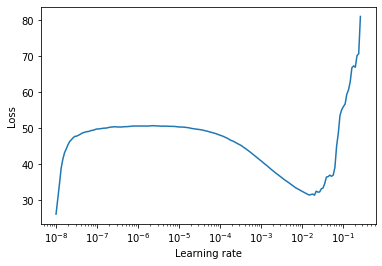

In [7]:
# Inspect results
fig = lr_finder.plot(); fig.show()
suggested_lr = lr_finder.suggestion()
print(suggested_lr)
# Overwrite lr and create new model
#hparams.lr = suggested_lr
#model = MyModelClass(hparams)


In [8]:
class Assignment13(LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.epoch_number = 0
        self.config = config
        self.train_csv_path = self.config.DATASET + "/train.csv"
        self.test_csv_path = self.config.DATASET + "/test.csv"
        self.train_loader, self.test_loader, self.train_eval_loader = get_loaders(
              train_csv_path=self.train_csv_path, test_csv_path=self.test_csv_path)
        self.check_class_accuracy = check_class_accuracy
        self.model = YOLOv3(num_classes=self.config.NUM_CLASSES)
        self.loss_fn = YoloLoss()
        self.check_class_accuracy = check_class_accuracy
        self.get_evaluation_bboxes = get_evaluation_bboxes
        self.scaled_anchors = (torch.tensor(self.config.ANCHORS) * torch.tensor(self.config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
        self.losses = []
        self.plot_couple_examples = plot_couple_examples
        self.mean_average_precision = mean_average_precision
        self.EPOCHS = self.config.NUM_EPOCHS * 2 // 5
    def forward(self, x):
        out = self.model(x)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        y0, y1, y2 = (y[0],y[1],y[2])
        loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0].to(y0))
                + self.loss_fn(out[1], y1, self.scaled_anchors[1].to(y1))
                + self.loss_fn(out[2], y2, self.scaled_anchors[2].to(y2))
            )
        self.losses.append(loss.item())
        mean_loss = sum(self.losses) / len(self.losses)
        self.log("train_loss", mean_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #self.log("train_loss", mean_loss)
        return loss


    def on_train_epoch_start(self):
        self.epoch_number += 1
        self.losses = []
        #self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)
        if self.epoch_number > 1 and self.epoch_number % 10 == 0:
            self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)

    def on_train_epoch_end(self):
        print(f"Currently epoch {self.epoch_number}")
        print("On Train Eval loader:")
        print("On Train loader:")
        self.check_class_accuracy(self.model, self.train_loader, threshold=self.config.CONF_THRESHOLD)
        if self.epoch_number == self.EPOCHS:
              #if self.epoch_number > 1 and self.epoch_number % 3 == 0:
            self.check_class_accuracy(self.model, self.test_loader, threshold=self.config.CONF_THRESHOLD)
            pred_boxes, true_boxes = self.get_evaluation_bboxes( self.test_loader,self.model,iou_threshold=self.config.NMS_IOU_THRESH,
                                                                 anchors=self.config.ANCHORS,
                                                                 threshold=self.config.CONF_THRESHOLD,)
            mapval = self.mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=self.config.MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=self.config.NUM_CLASSES,
            )
            print(f"MAP: {mapval.item()}")
            self.model.train()
            pass


    def configure_optimizers(self):
        optimizer = optimizer = optim.Adam(
                    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        #EPOCHS = config.NUM_EPOCHS * 2 // 5
        scheduler = OneCycleLR(
        optimizer,
        max_lr=8E-4,
        steps_per_epoch=len(self.train_loader),
        epochs=self.EPOCHS,
        pct_start=5/self.EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
        )

        return {"optimizer": optimizer, "lr_scheduler":scheduler}
        
     ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
          return self.train_loader

    def test_dataloader(self):
          return self.test_loader

    

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | YOLOv3   | 61.6 M
1 | loss_fn | YoloLoss | 0     
-------------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
123.253   Total estimated model params size (MB)


Currently epoch 1
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.55it/s]


Class accuracy is: 26.397440%
No obj accuracy is: 0.046775%
Obj accuracy is: 99.857803%
Currently epoch 2
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.55it/s]


Class accuracy is: 30.690569%
No obj accuracy is: 0.466076%
Obj accuracy is: 98.812660%
Currently epoch 3
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.53it/s]


Class accuracy is: 31.681749%
No obj accuracy is: 3.517017%
Obj accuracy is: 89.547089%
Currently epoch 4
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.54it/s]


Class accuracy is: 32.126404%
No obj accuracy is: 7.109501%
Obj accuracy is: 80.777725%
Currently epoch 5
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.55it/s]


Class accuracy is: 32.595238%
No obj accuracy is: 15.811263%
Obj accuracy is: 73.821770%
Currently epoch 6
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.55it/s]


Class accuracy is: 33.569969%
No obj accuracy is: 21.696772%
Obj accuracy is: 66.674980%
Currently epoch 7
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.55it/s]


Class accuracy is: 34.120605%
No obj accuracy is: 34.057407%
Obj accuracy is: 64.849159%
Currently epoch 8
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.54it/s]


Class accuracy is: 35.204319%
No obj accuracy is: 54.544140%
Obj accuracy is: 64.714935%
Currently epoch 9
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.54it/s]

Class accuracy is: 35.600727%
No obj accuracy is: 77.002663%
Obj accuracy is: 60.713367%


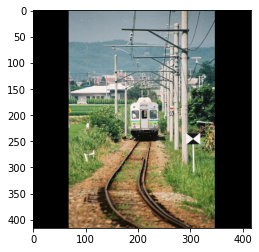

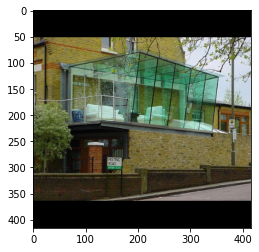

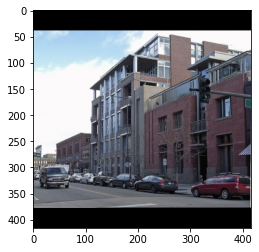

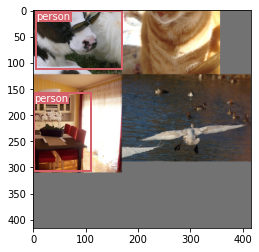

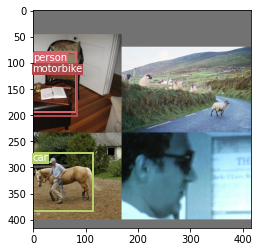

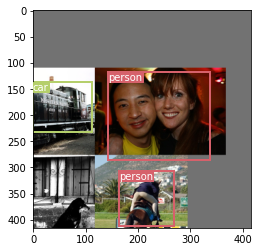

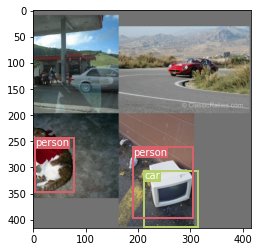

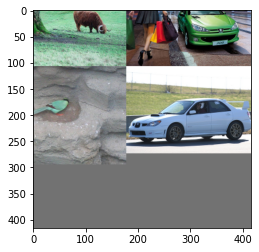

Currently epoch 10
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:34<00:00,  5.50it/s]


Class accuracy is: 36.220165%
No obj accuracy is: 86.998734%
Obj accuracy is: 58.592213%
Currently epoch 11
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.51it/s]


Class accuracy is: 36.542515%
No obj accuracy is: 90.015541%
Obj accuracy is: 59.334202%
Currently epoch 12
On Train Eval loader:
On Train loader:


 78%|███████▊  | 402/518 [01:13<00:20,  5.61it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 518/518 [01:33<00:00,  5.57it/s]

Class accuracy is: 62.801064%
No obj accuracy is: 95.764488%
Obj accuracy is: 75.418434%


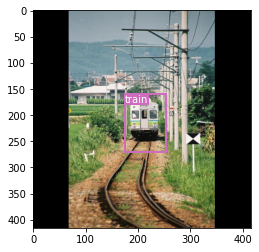

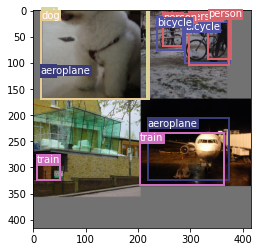

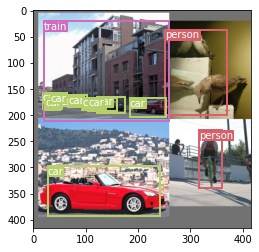

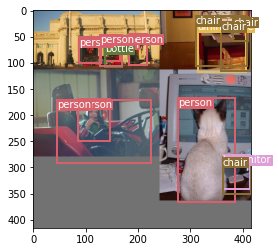

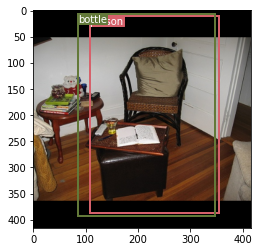

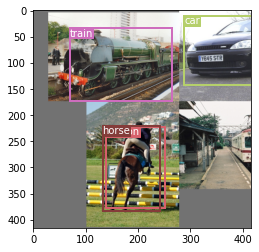

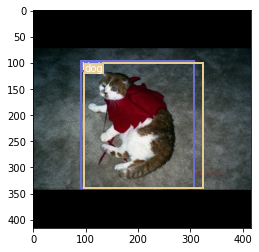

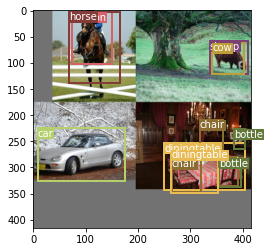

Currently epoch 40
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:33<00:00,  5.52it/s]


Class accuracy is: 63.562180%
No obj accuracy is: 95.861588%
Obj accuracy is: 75.760689%


100%|██████████| 155/155 [00:28<00:00,  5.42it/s]


Class accuracy is: 65.681992%
No obj accuracy is: 95.816345%
Obj accuracy is: 73.461174%


100%|██████████| 155/155 [34:48<00:00, 13.47s/it]
`Trainer.fit` stopped: `max_epochs=40` reached.


MAP: 0.21972306072711945


In [9]:
model = Assignment13()
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',  # Metric to monitor for saving the best model
    mode='min', # 'min' to save the model with the lowest value of the monitored metric
    dirpath='/storage/',
    filename='assignment13_final{epoch:02d}-train_loss_min_A400{train_loss:.2f}',
    save_top_k=1         # Save only the best model
)

trainer = Trainer(
    max_epochs=config.NUM_EPOCHS * 2 // 5,
    accelerator="gpu",
    precision=16,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"),TQDMProgressBar(refresh_rate=0),checkpoint_callback],
)


trainer.fit(model)

,lr-Adam,train_loss_step,train_loss_epoch
epoch,,,
NaN,0.000008,NaN,NaN
0.0,NaN,48.498138,NaN
NaN,0.000008,NaN,NaN
0.0,NaN,45.444714,NaN
NaN,0.000008,NaN,NaN


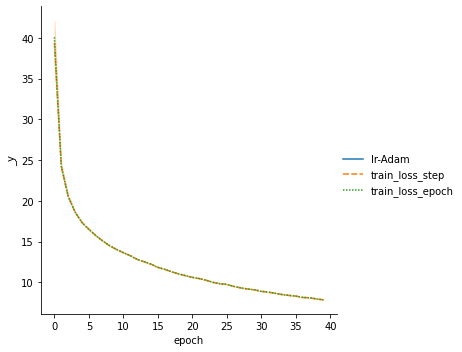

In [11]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")